In [2]:
import pandas as pd

# load the data
file_path = 'simulated_transaction_2024.csv'
data = pd.read_csv(file_path)
data.info(), data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230596 entries, 0 to 230595
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Date                    230367 non-null  object 
 1   Timestamp               230345 non-null  object 
 2   Account No              230372 non-null  float64
 3   Balance                 230350 non-null  float64
 4   Amount                  230387 non-null  float64
 5   Third Party Account No  6832 non-null    float64
 6   Third Party Name        223517 non-null  object 
dtypes: float64(4), object(3)
memory usage: 12.3+ MB


(None,
          Date Timestamp   Account No  Balance  Amount  Third Party Account No  \
 0  01/01/2023     00:00  678330503.0   2971.0  1584.0                     NaN   
 1  01/01/2023     00:00  472213568.0   3792.0  1950.0                     NaN   
 2  01/01/2023     00:00  472213568.0   3012.0  -780.0             283027736.0   
 3  01/01/2023     00:00  283027736.0   1787.0   780.0             472213568.0   
 4  01/01/2023     00:00  624500124.0   3226.0  1825.0                     NaN   
 
      Third Party Name  
 0  Westport Care Home  
 1    Barbiee Boutique  
 2                 NaN  
 3                 NaN  
 4            Fat Face  )

In [3]:
# delete the Date, Timestamp, Balance, Amount if they are na
data = data.dropna(subset=['Date','Timestamp','Account No', 'Balance', 'Amount'])
# when the Third Party Account and Name are null, delete them
data = data.dropna(subset=['Third Party Account No', 'Third Party Name'], how='all')

In [4]:
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100

missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

print(missing_summary)

                        Missing Values  Percentage
Date                                 0      0.0000
Timestamp                            0      0.0000
Account No                           0      0.0000
Balance                              0      0.0000
Amount                               0      0.0000
Third Party Account No          222389     97.0309
Third Party Name                  6805      2.9691


In [5]:
# check（Third Party Account No）and（Account No）
overlapping_accounts = data[data['Third Party Account No'].isin(data['Account No'])]

# Calculate the number of overlapping accounts
overlapping_count = overlapping_accounts.shape[0]

print(f" {overlapping_count} records where the third party account number overlaps with the account number.")


 6213 records where the third party account number overlaps with the account number.


In [6]:
# Find all unique account numbers where the third-party account number and the account number overlap in the transaction history.
overlapping_accounts_unique = data[data['Third Party Account No'].isin(data['Account No'])]['Account No'].unique()

overlapping_accounts_count = len(overlapping_accounts_unique)


In [7]:
# convert to data time
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

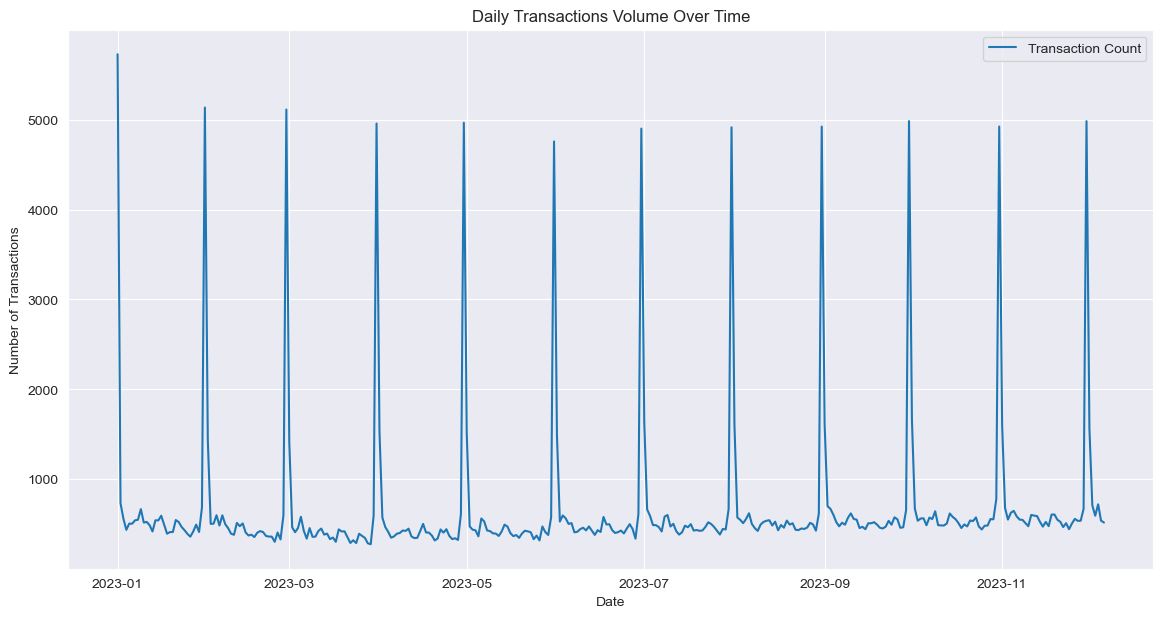

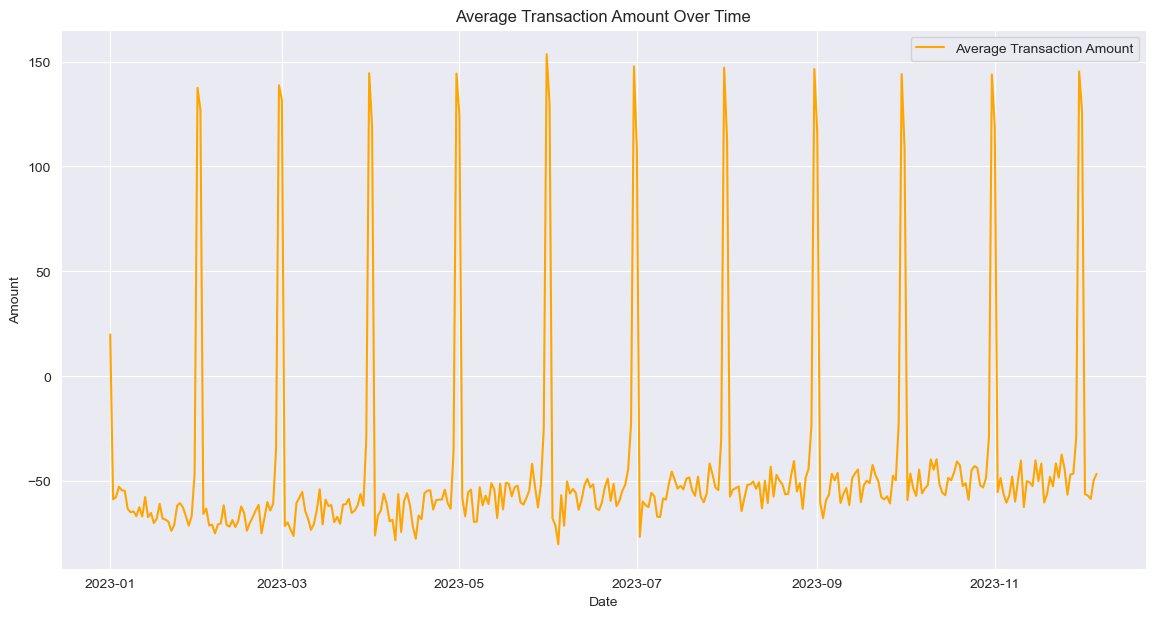

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics on transaction volume and average transaction amount by date
transactions_daily = data.groupby('Date').agg({'Amount': ['count', 'mean']}).reset_index()
transactions_daily.columns = ['Date', 'Transaction Count', 'Average Amount']

# Plotting trends in trading volume over time
plt.figure(figsize=(14, 7))
plt.plot(transactions_daily['Date'], transactions_daily['Transaction Count'], label='Transaction Count')
plt.title('Daily Transactions Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.legend()
plt.show()

# Plotting trends in average transaction amounts over time
plt.figure(figsize=(14, 7))
plt.plot(transactions_daily['Date'], transactions_daily['Average Amount'], label='Average Transaction Amount', color='orange')
plt.title('Average Transaction Amount Over Time')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.show()


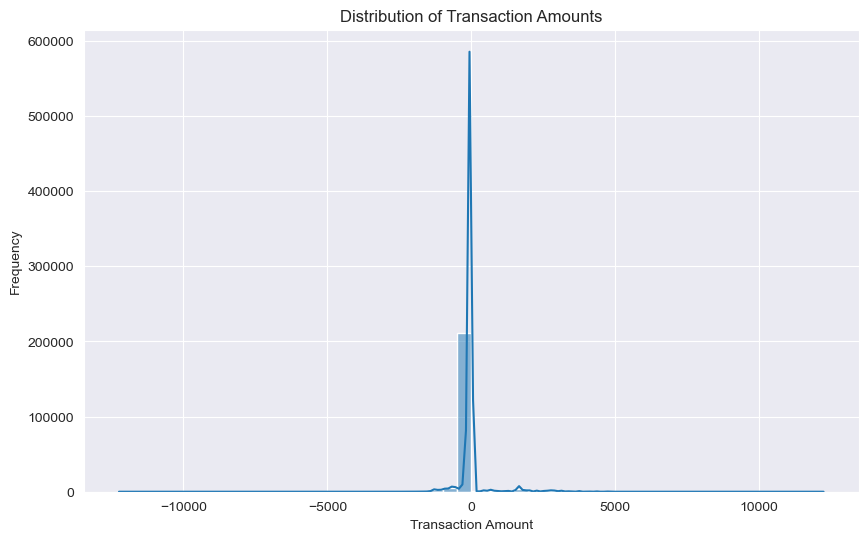

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

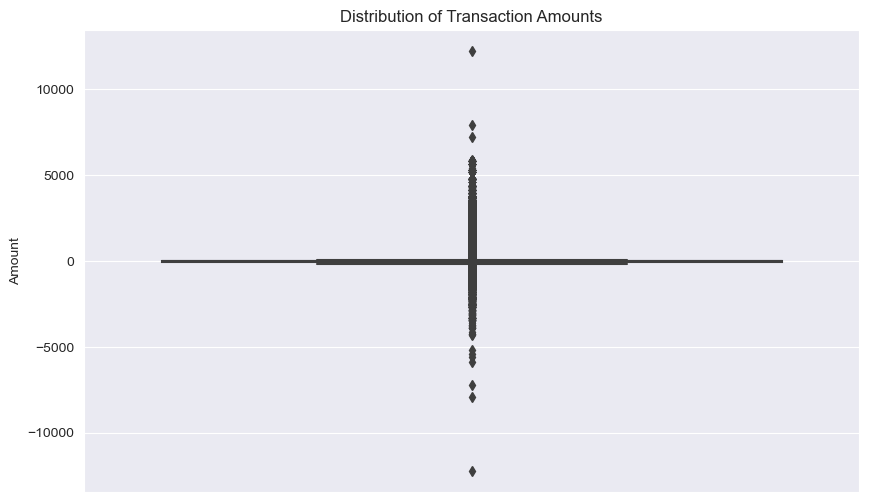

In [10]:
# Detecting Transaction Amount Distribution with Box Plots
plt.figure(figsize=(10, 6))
sns.boxplot(y=data['Amount'])
plt.title('Distribution of Transaction Amounts')
plt.ylabel('Amount')
plt.show()

In [11]:
from sklearn.svm import OneClassSVM
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Create a third-party account type profile, defining whether it is a company or an individual
data['third_party_type'] = data['Third Party Name'].apply(lambda x: 'Company' if pd.notnull(x) else 'Individual')

# Calculate the frequency of transactions per account
transaction_freq = data.groupby('Account No').size().reset_index(name='transaction_count')
data = pd.merge(data, transaction_freq, on='Account No', how='left')

# Calculate the average trade size, standard deviation of trade size and maximum/minimum trade size for each account
amount_stats = data.groupby('Account No')['Amount'].agg(['mean', 'std', 'max', 'min']).reset_index()
amount_stats.columns = ['Account No', 'avg_amount', 'std_amount', 'max_amount', 'min_amount']
data = pd.merge(data, amount_stats, on='Account No', how='left')

# Calculate the number of transactions per account with different third-party accounts
third_party_diversity = data.groupby('Account No')['Third Party Account No'].nunique().reset_index(name='num_third_party')
data = pd.merge(data, third_party_diversity, on='Account No', how='left')

# Extract hourly information
data['hour'] = pd.to_datetime(data['Timestamp'], format='%H:%M').dt.hour

# Creates an indication of whether or not it is a nightly transaction
data['is_night_transaction'] = (data['hour'] >= 0) & (data['hour'] < 6)

# Creates an identifier for whether the transaction amount is an integer or not
data['is_integer_amount'] = data['Amount'].apply(lambda x: 'Yes' if x.is_integer() else 'No')

# Extract weekly information
data['weekday'] = pd.to_datetime(data['Date'], format='%d/%m/%Y').dt.weekday.astype(str)

# Selection of numerical features for fraud detection
numeric_features = ['Amount', 'transaction_count', 'avg_amount', 'std_amount',
                    'max_amount', 'min_amount', 'num_third_party']

# Selecting category-based features for fraud detection
categorical_features = ['weekday', 'is_night_transaction', 'is_integer_amount', 'third_party_type']

# Normalisation of numerical features and unique heat coding of categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

data_transformed = preprocessor.fit_transform(data[numeric_features + categorical_features])

# Training and Prediction with Isolation Forest Models
clf_if = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.03, random_state=42)
clf_if.fit(data_transformed)
y_pred_if = clf_if.predict(data_transformed)

# Training and Prediction with One-Class SVM Models
clf_svm = OneClassSVM(nu=0.03, kernel="rbf", gamma=0.1)
clf_svm.fit(data_transformed)
y_pred_svm = clf_svm.predict(data_transformed)

# Combining the predictions of the two models
y_pred = np.logical_or(y_pred_if == -1, y_pred_svm == -1)


HIGH_RISK_USER_THRESHOLD = 10  # Threshold for high-risk users, if 10 or more instances are flagged as fraudulent
HIGH_RISK_THIRD_PARTY_THRESHOLD = 15  # High-risk third-party account thresholds, such as 20 or more transactions involving high-risk transactions

# Flag all transactions identified as fraudulent
fraud_transactions = data[y_pred]

# Count the number of fraudulent transactions per user (Account No)
user_fraud_count = fraud_transactions.groupby('Account No').size().reset_index(name='fraud_count')

# Flagging high-risk users with a number of fraudulent transactions above a threshold value
high_risk_users = user_fraud_count[user_fraud_count['fraud_count'] > HIGH_RISK_USER_THRESHOLD]['Account No']

# Extract all transaction records (including payments and receipts) involving high-risk users
high_risk_transactions = data[(data['Account No'].isin(high_risk_users)) | (data['Third Party Account No'].isin(high_risk_users))]

# Count the number of times each Third Party Account No. appears in high-risk transactions.
third_party_risk = high_risk_transactions.groupby('Third Party Account No').size().reset_index(name='risk_count')

# Flag high-risk third-party accounts that have exceeded a threshold number of risks
high_risk_third_parties = third_party_risk[third_party_risk['risk_count'] > HIGH_RISK_THIRD_PARTY_THRESHOLD]['Third Party Account No']

# Remove high-risk users from high-risk third-party lists
high_risk_third_parties = high_risk_third_parties[~high_risk_third_parties.isin(high_risk_users)]

print(f"Identified {len(fraud_transactions)} potentially fraudulent transactions.")
print(f"Identified {len(high_risk_users)} high-risk users.")
print(f"Identified {len(high_risk_third_parties)} high-risk third-party accounts.")

Identified 11363 potentially fraudulent transactions.
Identified 328 high-risk users.
Identified 25 high-risk third-party accounts.
